# The dataset has been downloaded and stored in the local directory and being used in this instead of a smaller chunk of it.
# In this code a time series problem has been transformed into a supervised learning problem with velocities of 8 previous input time steps and output of 5 future time steps.
# The data of only a unique vehicle ID has been fetched and used for the model training and predictions.
# MLP model has been trained with dense input and output layers, predictions were made over the test dataset and has been plotted against the true values.
# The entire prediction values of time t has beem tried to compare in a plot.

In [160]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '5,6'
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5,6"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [161]:
# Using seaborn for pairplot.
!pip install -q seaborn
!pip install -q tensorflow

In [162]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

print(tf.__version__)

2.14.0


In [163]:
# Load the CSV file
df = pd.read_csv('../Next_Generation_Simulation__NGSIM__Vehicle_Trajectories_and_Supporting_Data_20240819.csv')

# Select the required columns
required_columns = ['Global_X', 'Global_Y', 'v_Vel', 'v_Acc', 'Global_Time', 'Vehicle_ID']
velocity_dataset = df[required_columns]

In [164]:
velocity_dataset.shape

(9455901, 6)

In [165]:
velocity_dataset.head()

,Global_X,Global_Y,v_Vel,v_Acc,Global_Time,Vehicle_ID
0,6451203.729,1873252.549,23.31,2.05,1118848075000,515
1,6451203.729,1873252.549,23.31,2.05,1118848075000,515
2,6042814.264,2133542.012,26.54,-0.76,1113437421700,2224
3,6452425.122,1872172.475,37.52,11.20,1118847624800,2127
4,6452347.673,1872258.452,41.99,0.10,1118848324700,1033


In [166]:
velocity_dataset_sorted = velocity_dataset.sort_values(by=['Vehicle_ID', 'Global_Time']).reset_index(drop=True)

In [167]:
velocity_dataset_sorted

,Global_X,Global_Y,v_Vel,v_Acc,Global_Time,Vehicle_ID
0,6042841.908,2133120.155,12.50,0.00,1113433136300,1
1,6042839.670,2133135.799,14.64,0.08,1113433137500,1
2,6042839.214,2133138.665,14.59,-0.54,1113433137700,1
3,6042838.525,2133142.971,14.13,-3.49,1113433138000,1
4,6042837.417,2133153.456,13.00,0.00,1113433138800,1
...,...,...,...,...,...,...
9455896,6042608.928,2134671.977,63.93,-11.20,1113433457400,3366
9455897,6042607.952,2134678.398,62.22,-11.20,1113433457500,3366
9455898,6042606.994,2134684.573,62.22,0.00,1113433457600,3366
9455899,6042606.083,2134690.504,62.22,0.00,1113433457700,3366


In [168]:
# Count the number of unique vehicle IDs
unique_vehicle_ids = velocity_dataset['Vehicle_ID'].nunique()
print(f"Number of unique vehicle IDs: {unique_vehicle_ids}")

# Count how many rows of data each vehicle ID has
vehicle_counts = velocity_dataset['Vehicle_ID'].value_counts()

# Display the counts of rows for each vehicle ID
print("\nNumber of rows for each vehicle ID:")
print(vehicle_counts)

Number of unique vehicle IDs: 3233

Number of rows for each vehicle ID:
396     8311
705     7508
567     7441
601     7253
468     7206
        ... 
2897     167
2806      78
2815      70
2810      66
2781      60
Name: Vehicle_ID, Length: 3233, dtype: int64


In [169]:
# Access the count for a particular vehicle ID
specific_vehicle_id = 396
num_rows = vehicle_counts[specific_vehicle_id]

print(f"The vehicle ID '{specific_vehicle_id}' has {num_rows} rows of data.")

single_vehicle_data = velocity_dataset_sorted[velocity_dataset_sorted['Vehicle_ID'] == specific_vehicle_id]

The vehicle ID '396' has 8311 rows of data.


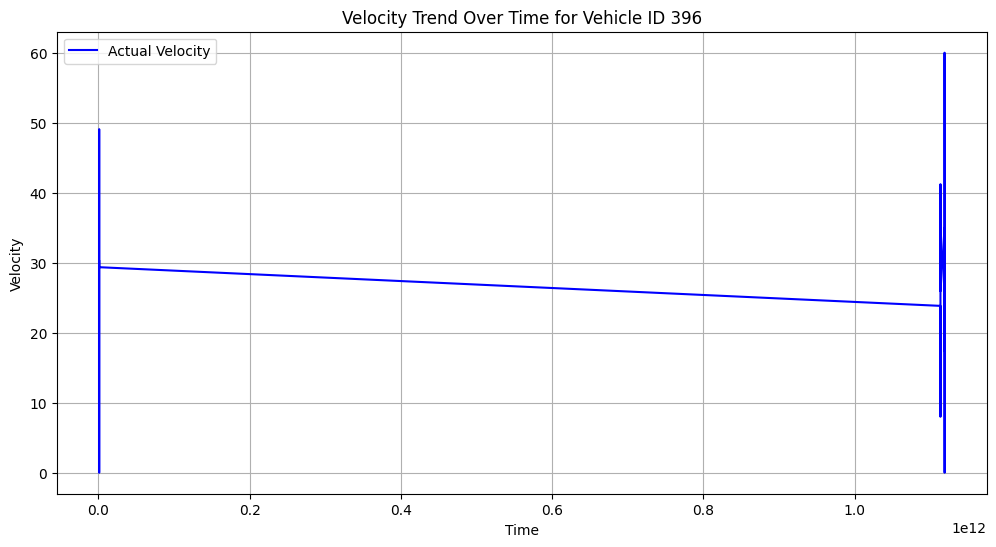

In [170]:
# Assuming 'single_vehicle_data' contains the data for a specific vehicle ID
# Extracting the time and velocity columns
time = single_vehicle_data['Global_Time'].values
velocity = single_vehicle_data['v_Vel'].values

# Plot the velocity trend over time
plt.figure(figsize=(12, 6))
plt.plot(time, velocity, label='Actual Velocity', color='blue')
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('Velocity Trend Over Time for Vehicle ID {}'.format(specific_vehicle_id))
plt.legend()
plt.grid(True)
plt.show()

In [171]:
# # Plot velocity over time
# plt.figure(figsize=(12, 6))
# plt.plot(velocity_dataset_sorted['Global_Time'], velocity_dataset_sorted['v_Vel'], label='Velocity')
# plt.xlabel('Global Time (ms)')
# plt.ylabel('Velocity (v_vel)')
# plt.title('Velocity Evolution Over Time')
# plt.legend()
# plt.grid(True)
# plt.show()

In [172]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    # Ensure data is in 2D format (n_samples, n_features)
    df_s = pd.DataFrame(data)
    cols, names = [], []
    
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df_s.shift(i))
        names += [f'var1(t-{i})']
        
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df_s.shift(-i))
        if i == 0:
            names += [f'var1(t)']
        else:
            names += [f'var1(t+{i})']
    
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    
    return agg

In [173]:
# Extract the velocity column
velocities = single_vehicle_data['v_Vel'].values

# Convert the velocity time series into a supervised learning problem
n_in = 8  # Number of previous time steps to use as input
n_out = 5  # Number of future time steps to predict (5 step ahead)
supervised_data = series_to_supervised(velocities, n_in=n_in, n_out=n_out)

# Time Steps:   t-8   t-7   t-6   t-5   t-4   t-3   t-2   t-1   t  t+1  t+2  t+3  t+4
# Values:      [ x ,  x ,  x ,  x ,  x ,  x ,  x ,  x ] -> [ y ,  y ,  y,  y,  y]

# Print the first few rows to verify the transformation
print(supervised_data.head())

    var1(t-8)  var1(t-7)  var1(t-6)  var1(t-5)  var1(t-4)  var1(t-3)  \
8       30.25      30.25      30.25      30.25      30.25      30.25   
9       30.25      30.25      30.25      30.25      30.25      30.24   
10      30.25      30.25      30.25      30.25      30.24      30.24   
11      30.25      30.25      30.25      30.24      30.24      30.24   
12      30.25      30.25      30.24      30.24      30.24      30.24   

    var1(t-2)  var1(t-1)  var1(t)  var1(t+1)  var1(t+2)  var1(t+3)  var1(t+4)  
8       30.24      30.24    30.24      30.24      30.23      30.23      30.23  
9       30.24      30.24    30.24      30.23      30.23      30.23      30.23  
10      30.24      30.24    30.23      30.23      30.23      30.23      30.23  
11      30.24      30.23    30.23      30.23      30.23      30.23      30.23  
12      30.23      30.23    30.23      30.23      30.23      30.23      30.22  


In [174]:
# Split the supervised data into training, validation, and test sets
n_train = int(len(supervised_data) * 0.7)
n_validation = int(len(supervised_data) * 0.15)

train_data = supervised_data[:n_train]
validation_data = supervised_data[n_train:n_train + n_validation]
test_data = supervised_data[n_train + n_validation:]

# Separate inputs (X) and outputs (y)
X_train, y_train = train_data.iloc[:, :-n_out].values, train_data.iloc[:, -n_out:].values
X_validation, y_validation = validation_data.iloc[:, :-n_out].values, validation_data.iloc[:, -n_out:].values
X_test, y_test = test_data.iloc[:, :-n_out].values, test_data.iloc[:, -n_out:].values

In [175]:
# Reshape data for MLP (samples, time steps)
X_train = X_train.reshape((X_train.shape[0], n_in))
X_validation = X_validation.reshape((X_validation.shape[0], n_in))
X_test = X_test.reshape((X_test.shape[0], n_in))

In [176]:
print(len(y_test))
print(X_test.shape)
print(y_test.shape)

1246
(1246, 8)
(1246, 5)


In [177]:
# Define the updated MLP model
mlp_model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(n_in,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(n_out)  # Output layer
])

# Compile the model with 'adam' optimizer and MSE loss
mlp_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# Early stopping callback to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model
history = mlp_model.fit(X_train, y_train, epochs=50, batch_size=32, 
                         validation_data=(X_validation, y_validation), 
                         verbose=1, callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss = mlp_model.evaluate(X_test, y_test, batch_size=len(X_test), verbose=1)
print(f"Test Loss: {test_loss}")

# Compute RMSE
rmse = np.sqrt(test_loss)
print(f"RMSE on the test set: {rmse:.4f}")

Epoch 1/50
182/182 [==============================] - 2s 5ms/step - loss: 72.1922 - val_loss: 9.8951
Epoch 2/50
182/182 [==============================] - 1s 4ms/step - loss: 54.5329 - val_loss: 8.9431
Epoch 3/50
182/182 [==============================] - 1s 4ms/step - loss: 52.5431 - val_loss: 7.8607
Epoch 4/50
182/182 [==============================] - 1s 4ms/step - loss: 51.4730 - val_loss: 7.6120
Epoch 5/50
182/182 [==============================] - 1s 4ms/step - loss: 51.0316 - val_loss: 7.1618
Epoch 6/50
182/182 [==============================] - 1s 4ms/step - loss: 50.8048 - val_loss: 6.6806
Epoch 7/50
182/182 [==============================] - 1s 4ms/step - loss: 50.3289 - val_loss: 7.2167
Epoch 8/50
182/182 [==============================] - 1s 4ms/step - loss: 50.0799 - val_loss: 7.6323
Epoch 9/50
182/182 [==============================] - 1s 4ms/step - loss: 49.9558 - val_loss: 6.3919
Epoch 10/50
182/182 [==============================] - 1s 4ms/step - loss: 49.7691 - val_lo

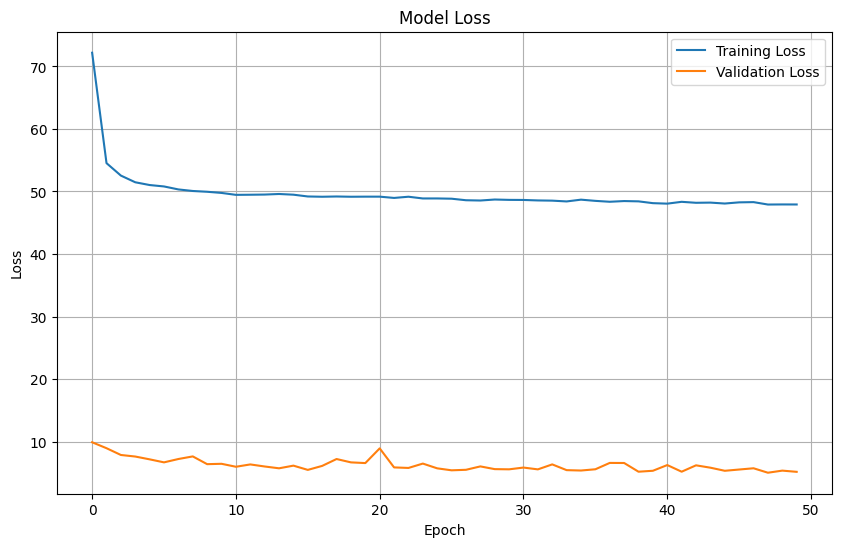

In [178]:
# Plotting training & validation loss curve
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history.get('val_loss'), label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [179]:
mlp_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_108 (Dense)           (None, 128)               1152      
                                                                 
 dense_109 (Dense)           (None, 64)                8256      
                                                                 
 dense_110 (Dense)           (None, 32)                2080      
                                                                 
 dense_111 (Dense)           (None, 32)                1056      
                                                                 
 dense_112 (Dense)           (None, 5)                 165       
                                                                 
Total params: 12709 (49.64 KB)
Trainable params: 12709 (49.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [180]:
# Initialize a list to store all predictions
all_predictions = []

# Initialize the starting index
i = 0

# Loop through the test dataset, making predictions and skipping forward by 5 steps each time
while i < len(X_test):
    # Extract the current sequence from the test set (n_in time steps)
    current_sequence = X_test[i]

    # Reshape it for prediction (1 sample, n_in time steps, 1 feature)
    current_sequence = current_sequence.reshape(1, current_sequence.shape[0])
        
    # Debugging print statements
    print(f"i = {i}, current_sequence shape = {current_sequence.shape}")

    # Predict the next 5 velocities based on the current sequence
    next_5_velocities = mlp_model.predict(current_sequence, verbose=0)  # Shape: (1, 5)

    # Append the 5 predicted velocities to the all_predictions list
    all_predictions.extend(next_5_velocities.flatten())  # Flatten and append

    # Skip forward by 5 time steps
    i += 5

# Print the predicted velocities for the test dataset
print("Predicted velocities for the test dataset are:", all_predictions)

i = 0, current_sequence shape = (1, 8)
i = 5, current_sequence shape = (1, 8)
i = 10, current_sequence shape = (1, 8)
i = 15, current_sequence shape = (1, 8)
i = 20, current_sequence shape = (1, 8)
i = 25, current_sequence shape = (1, 8)
i = 30, current_sequence shape = (1, 8)
i = 35, current_sequence shape = (1, 8)
i = 40, current_sequence shape = (1, 8)
i = 45, current_sequence shape = (1, 8)
i = 50, current_sequence shape = (1, 8)
i = 55, current_sequence shape = (1, 8)
i = 60, current_sequence shape = (1, 8)
i = 65, current_sequence shape = (1, 8)
i = 70, current_sequence shape = (1, 8)
i = 75, current_sequence shape = (1, 8)
i = 80, current_sequence shape = (1, 8)
i = 85, current_sequence shape = (1, 8)
i = 90, current_sequence shape = (1, 8)
i = 95, current_sequence shape = (1, 8)
i = 100, current_sequence shape = (1, 8)
i = 105, current_sequence shape = (1, 8)
i = 110, current_sequence shape = (1, 8)
i = 115, current_sequence shape = (1, 8)
i = 120, current_sequence shape = (1, 

i = 1005, current_sequence shape = (1, 8)
i = 1010, current_sequence shape = (1, 8)
i = 1015, current_sequence shape = (1, 8)
i = 1020, current_sequence shape = (1, 8)
i = 1025, current_sequence shape = (1, 8)
i = 1030, current_sequence shape = (1, 8)
i = 1035, current_sequence shape = (1, 8)
i = 1040, current_sequence shape = (1, 8)
i = 1045, current_sequence shape = (1, 8)
i = 1050, current_sequence shape = (1, 8)
i = 1055, current_sequence shape = (1, 8)
i = 1060, current_sequence shape = (1, 8)
i = 1065, current_sequence shape = (1, 8)
i = 1070, current_sequence shape = (1, 8)
i = 1075, current_sequence shape = (1, 8)
i = 1080, current_sequence shape = (1, 8)
i = 1085, current_sequence shape = (1, 8)
i = 1090, current_sequence shape = (1, 8)
i = 1095, current_sequence shape = (1, 8)
i = 1100, current_sequence shape = (1, 8)
i = 1105, current_sequence shape = (1, 8)
i = 1110, current_sequence shape = (1, 8)
i = 1115, current_sequence shape = (1, 8)
i = 1120, current_sequence shape =

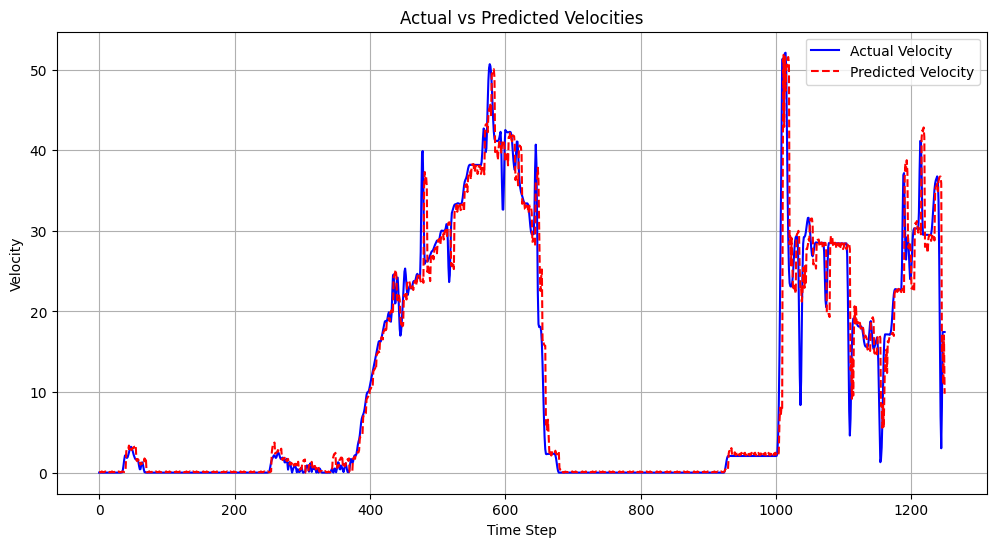

In [181]:
# Extracting the true values from the test set
true_values_to_compare = y_test[::5, :].flatten()  # Only take every 5th row, then flatten

# Plotting the actual and predicted velocities
plt.figure(figsize=(12, 6))

# Plot the actual velocities
plt.plot(np.arange(len(true_values_to_compare)), true_values_to_compare, label='Actual Velocity', color='blue')

# Plot the predicted velocities
plt.plot(np.arange(len(all_predictions)), all_predictions, label='Predicted Velocity', color='red', linestyle='--')

plt.xlabel('Time Step')
plt.ylabel('Velocity')
plt.title('Actual vs Predicted Velocities')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [182]:
true_values_df = np.array(true_values_to_compare)
predictions_values_df = np.array(all_predictions)

# Ensure both arrays have identical shapes
assert true_values_df.shape == predictions_values_df.shape, "Datasets must have the same shape!"

# Calculate RMSE using the mathematical formula
def calculate_rmse(true_values, predicted_values):
    # Calculate the mean square error
    mse = np.mean((true_values - predicted_values) ** 2)
    # Take the square root of the mean square error to get RMSE
    rmse = np.sqrt(mse)
    return rmse

# Apply RMSE calculation on all values
rmse = calculate_rmse(true_values_df, predictions_values_df)

print(f"Root Mean Square Error (RMSE): {rmse}")

Root Mean Square Error (RMSE): 3.8601329207220174
